<a href="https://colab.research.google.com/github/stepan-fukalov/ml/blob/master/image_colorization_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorization using Autoencoder model

In [ ]:
! pip  install icecream -q
from icecream import ic

In [ ]:
import os
import gdown
import skimage
import random
import zipfile
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Subset, random_split
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def is_HWC_format(image: np.ndarray):
  return (image.ndim == 3 and image.shape[2] == 3)

def is_CHW_format(image: np.ndarray):
  return (image.ndim == 3 and image.shape[0] == 3)

def toCHW(image: np.ndarray):
  assert(is_HWC_format(image))
  return image.transpose(2, 0, 1)

def toHWC(image: np.ndarray):
  assert(is_CHW_format(image))
  return image.transpose(1, 2, 0)

def rgb2lab(image: np.ndarray):
  assert(is_HWC_format(image))
  return skimage.color.rgb2lab(image, channel_axis=2)

def lab2rgb(image: np.ndarray):
  assert(is_HWC_format(image))
  return skimage.color.lab2rgb(image, channel_axis=2)

def make_lab_bw(image: np.ndarray):
  assert(is_HWC_format(image))
  image = toCHW(image)
  image[1] = np.zeros_like(image[1])
  image[2] = np.zeros_like(image[2])
  image = toHWC(image)
  return image

def imshow(image, title=None, color_scheme='rgb'):
  assert(is_HWC_format(image))
  show_image = image.copy()
  if color_scheme == 'lab':
    show_image = lab2rgb(show_image)
  if title:
    plt.title(title)
  plt.imshow(show_image)

def imshow_multiple(images, titles, color_scheme='rgb'):
  fig = plt.figure(figsize=(15, 10))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx+1)
    imshow(image, title, color_scheme)
  fig.show()

def get_random_image_from_dataset(dataset):
  rand_idx = random.randrange(len(dataset))
  return dataset[rand_idx][0]

device = "cuda" if torch.cuda.is_available() else "cpu"

### 1.1 Download and unpack dataset

In [ ]:
url_dataset = "https://drive.google.com/file/d/1cVvbb28jhcXAlYA8YPKyESI1ybKXXyV-/view?usp=share_link"
gdown.download(url=url_dataset,
               quiet=True,
               fuzzy=True)

with zipfile.ZipFile("animal_images.zip") as zip_ref:
  zip_ref.extractall("animal_images")

## 2. Exploring data

In [ ]:
class AnimalDataset(ImageFolder):
  def __init__(self, root):
    super().__init__(root=root)

  def __getitem__(self, index):
    img, target = super().__getitem__(index)
    img = torch.Tensor(toCHW(rgb2lab(np.array(img))))
    transform = transforms.Resize((64, 64), antialias=True)
    img = transform(img)
    return img, target

In [ ]:
animal_dataset = AnimalDataset("animal_images")

In [ ]:
indices = torch.arange(1000)
animal_dataset = Subset(animal_dataset, indices)
train_size = int(0.8*len(animal_dataset))
test_size = len(animal_dataset)-train_size
trainset, testset = random_split(animal_dataset, [train_size, test_size])

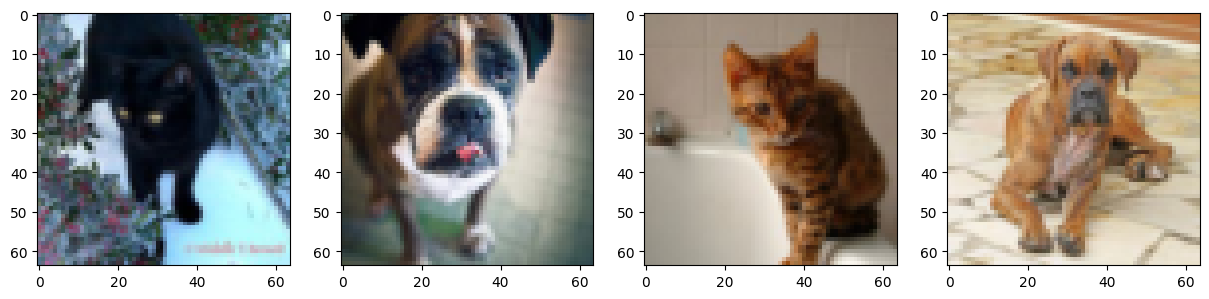

In [ ]:
def show_random_dataset_images(dataset, count, color_scheme='rgb'):
  rand_sample = random.sample(range(len(dataset)), count) 
  images = [dataset[idx][0] for idx in rand_sample]
  images = [toHWC(image.numpy()) for image in images]
  imshow_multiple(images, [None]*count, color_scheme)

show_random_dataset_images(trainset, 4, 'lab')

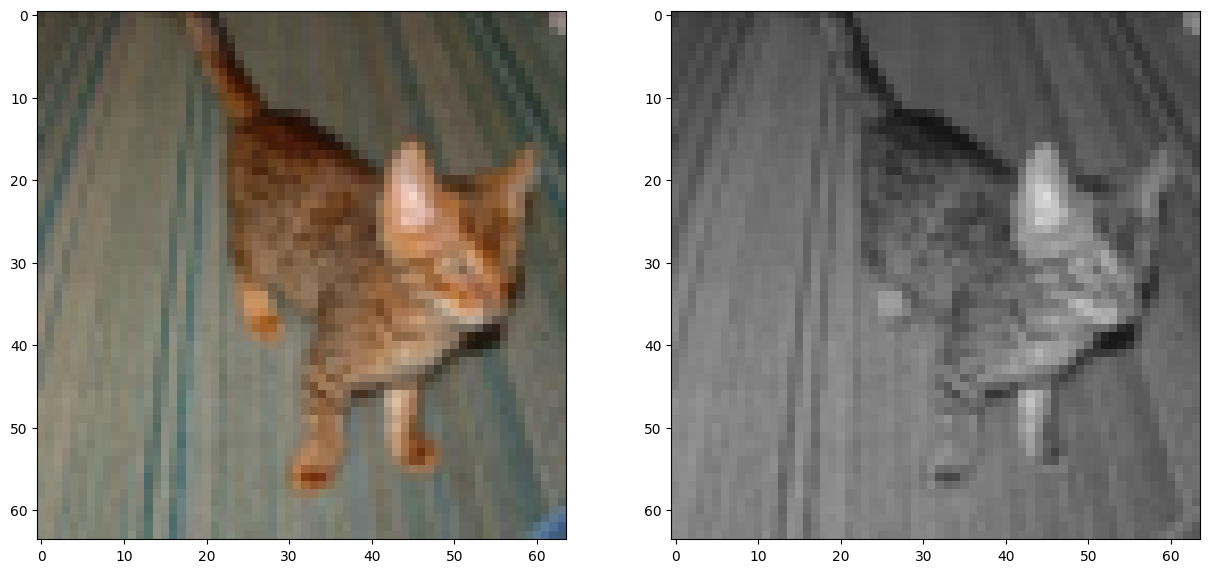

In [ ]:
image = get_random_image_from_dataset(trainset)
image = toHWC(image.numpy())

fig = plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
imshow(image, color_scheme='lab')

plt.subplot(1, 2, 2)
image_bw = make_lab_bw(image)
imshow(image_bw, color_scheme='lab')


In [ ]:
batch_size = 32

trainloader = torch.utils.data.DataLoader(trainset,
                         batch_size=batch_size,
                         shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                         batch_size=batch_size,
                         shuffle=False)

## 3. Building and training models

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  """Performs a training with model trying to learn on dataloader."""
  train_loss = 0

  # Put model into training mode
  model.train()

  for batch, (X_Lab, _) in enumerate(dataloader):
    
    X_L = X_Lab[:, 0].unsqueeze(dim=1)
    X_ab = X_Lab[:, 1:]

    # 2. Send data to target device
    X_L = X_L.to(device)

    # 2. Forward pass
    X_pred = model(X_L)

    # 3. Calculate the loss
    loss = loss_fn(X_pred.cpu(), X_ab)
    train_loss += loss.item()

    # 4. Optimizer zero grad
    optimizer.zero_grad()

    # 5. Loss backward
    loss.backward()

    # 6. Optimizer step
    optimizer.step()

  # Divide total train loss by length of train dataloader
  train_loss /= len(trainloader)
  return train_loss

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  """Performs a testing loop step on model going over dataloader."""
  test_loss = 0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X_Lab, _ in dataloader:
      
      X_L = X_Lab[:, 0].unsqueeze(dim=1)
      X_ab = X_Lab[:, 1:]

      # 2. Send data to target device
      X_L = X_L.to(device)

      # 2. Forward pass
      X_pred = model(X_L)

      # 3. Calculate the loss
      loss = loss_fn(X_pred.cpu(), X_ab)
      test_loss += loss.item()

    # Divide total test loss by length of train dataloader
    test_loss /= len(dataloader) 
  return test_loss     

In [ ]:
def train_model(model: torch.nn.Module,
                epochs: int):  
  all_train_loss = []
  all_test_loss = []
  tbar = tqdm(range(epochs))
  for epoch in tbar:
    train_loss = train_step(model=model,
                            dataloader=trainloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer)
    test_loss = test_step(model=model,
                          dataloader=testloader,
                          loss_fn=loss_fn)
    all_train_loss.append(train_loss)
    all_test_loss.append(test_loss)
    tbar.set_description(f"Epoch: {epoch} | \
    Train loss: {train_loss:.2f} | \
    Test loss: {test_loss:.2f}")

  plt.plot(all_train_loss, label="Train loss")
  plt.plot(all_test_loss, label="Test loss")
  plt.legend()

In [ ]:
def predict_and_plot_image(model: torch.nn.Module,
                           image: torch.Tensor):
  model.eval()
  with torch.inference_mode():
    image_L = image[0].unsqueeze(dim=0)
    image_ab = image[1:]

    image_L = image_L.to(device)
    image_pred = model(image_L.unsqueeze(dim=0)).squeeze().cpu().numpy()
    output_image = np.array([image_L[0].cpu().numpy(), image_pred[0], image_pred[1]])
    output_image = toHWC(output_image)
    imshow_multiple([toHWC(image.numpy()), output_image], ["Original", "Predicted"], 'lab')

### 3.1 Autoencoder 1


In [ ]:
class AEv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=32,
                  kernel_size=4,
                  stride=2,
                  padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,
                  out_channels=64,
                  kernel_size=4,
                  stride=2,
                  padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=64,
                          out_channels=32,
                          kernel_size=4,
                          stride=2,
                          padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=32,
                          out_channels=2,
                          kernel_size=4,
                          stride=2,
                          padding=1)
    )

  def forward(self, x):
    x = self.layer(x)
    return x

In [ ]:
model_0 = AEv1().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_0.parameters())

  0%|          | 0/100 [00:00<?, ?it/s]

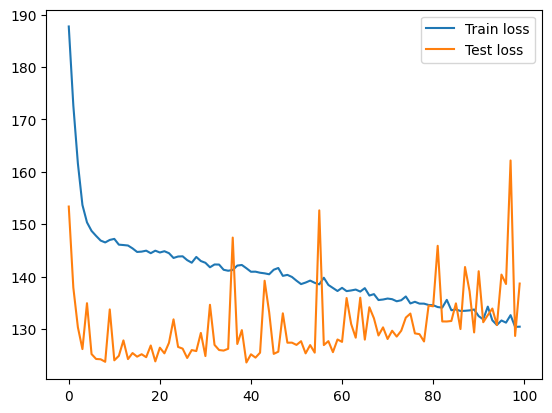

In [ ]:
train_model(model=model_0,
            epochs=100)

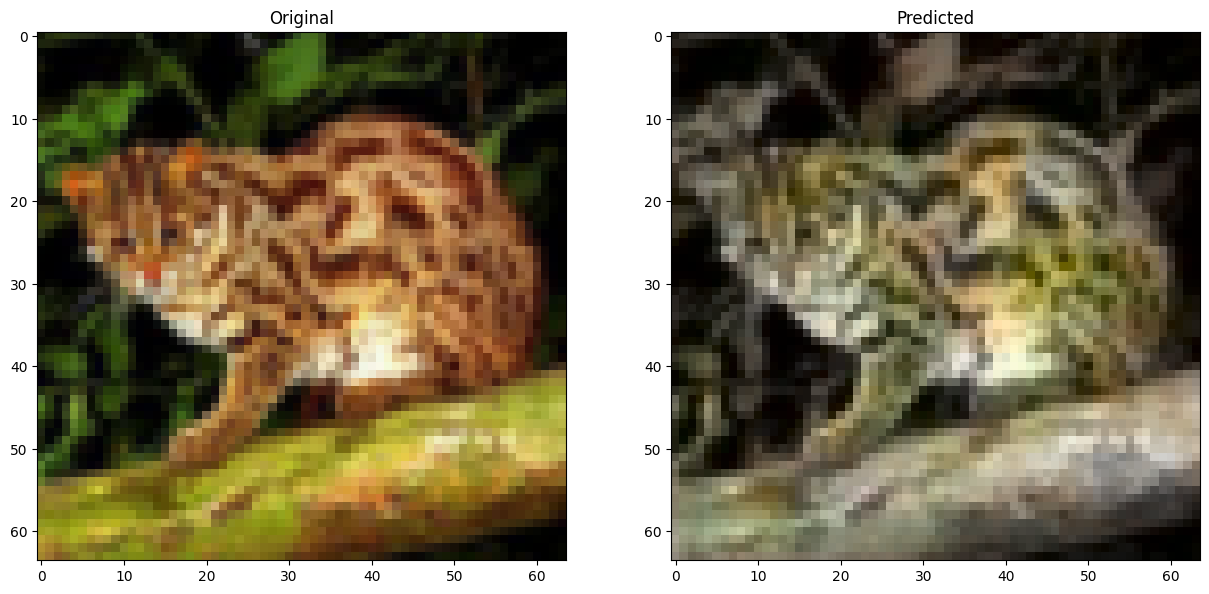

In [ ]:
random_image = get_random_image_from_dataset(testset)
predict_and_plot_image(model_0, random_image)

### 3.2. Autoencoder 2

In [ ]:
class AEv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=32,
                  kernel_size=4,
                  stride=2,
                  padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,
                  out_channels=64,
                  kernel_size=4,
                  stride=2,
                  padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,
                  out_channels=128,
                  kernel_size=4,
                  stride=2,
                  padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=128,
                          out_channels=64,
                          kernel_size=4,
                          stride=2,
                          padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=64,
                          out_channels=32,
                          kernel_size=4,
                          stride=2,
                          padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=32,
                          out_channels=2,
                          kernel_size=4,
                          stride=2,
                          padding=1)
    )

  def forward(self, x):
    x = self.layer(x)
    return x

In [ ]:
model_1 = AEv2().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_1.parameters())

  0%|          | 0/5 [00:00<?, ?it/s]

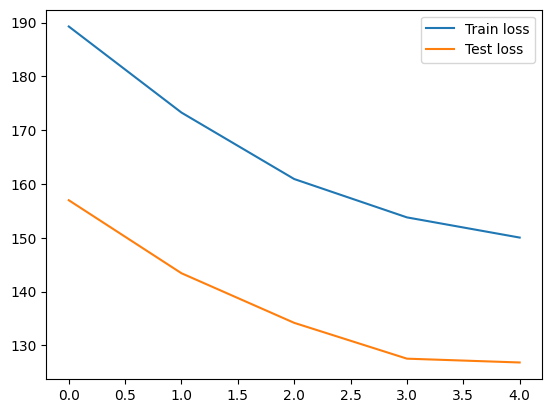

In [ ]:
train_model(model=model_1,
            epochs=5)  

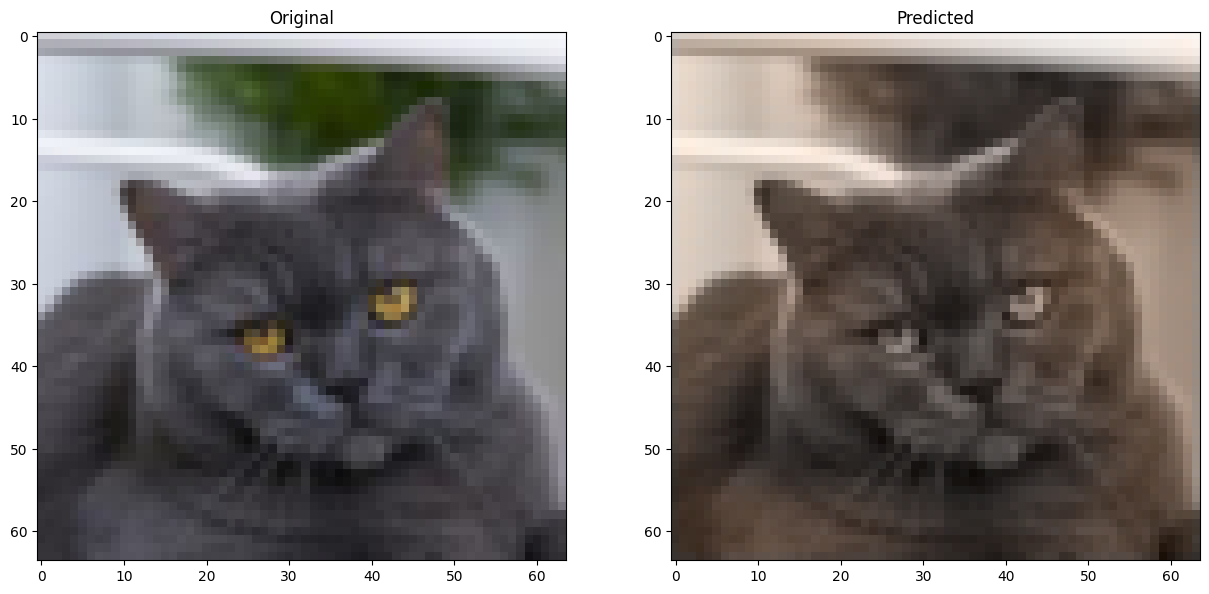

In [ ]:
random_image = get_random_image_from_dataset(testset)
predict_and_plot_image(model_1, random_image)

### 3.2 UNet Model


In [ ]:
# Pytorch-Unet model by milesial from https://github.com/milesial/Pytorch-UNet.git
!git clone "https://github.com/milesial/Pytorch-UNet.git" git/unetmodel -q

fatal: destination path 'git/unetmodel' already exists and is not an empty directory.


In [ ]:
from git.unetmodel.unet import UNet
model_2 = UNet(n_channels=1,
             n_classes=2).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_2.parameters())

  0%|          | 0/5 [00:00<?, ?it/s]

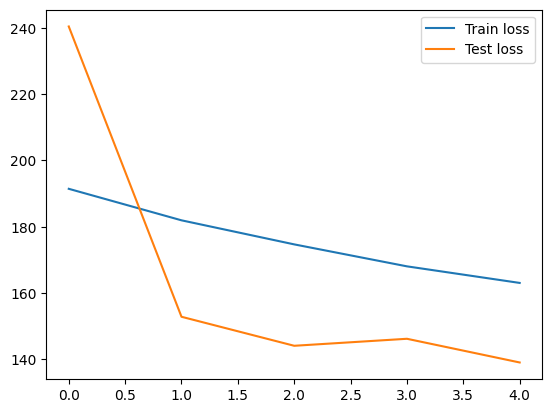

In [ ]:
train_model(model=model_2,
            epochs=5)

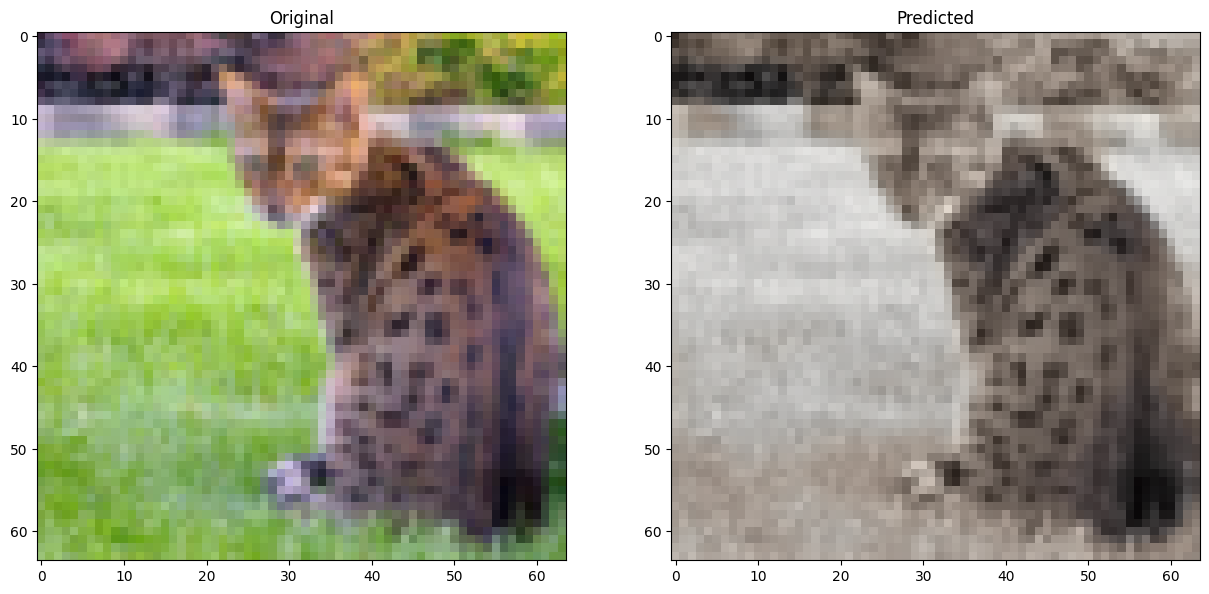

In [ ]:
random_image = get_random_image_from_dataset(testset)
predict_and_plot_image(model_2, random_image)